In [1]:
import notebook_functions
reload(notebook_functions)
from notebook_functions import *
import os, pandas as pd, cPickle as pickle
from nolearn.lasagne.visualize import plot_conv_activity, plot_conv_weights, plot_occlusion
from lasagne.layers import get_output, get_output_shape
import theano.tensor as T
import theano
%pylab inline

Couldn't import dot_parser, loading of dot files will not be possible.
Populating the interactive namespace from numpy and matplotlib

Using gpu device 0: GeForce GTX 960 (CNMeM is disabled, CuDNN 4004)

pylab import has clobbered these variables: ['ceil', 'floor']
`%matplotlib` prevents importing * from pylab and numpy


In [2]:
val_dir =  "/media/dylan/Science/Kaggle-Data/distracted_drivers/test/"

In [3]:
def image_gen_from_dir_with_filenames(data_dir, batches, size):
    result = [os.path.join(dp, f) for dp, dn, filenames in os.walk(data_dir) 
                  for f in filenames if os.path.splitext(f)[1] == '.jpg']
    image_files = []
    filenames = []
    for file_path in result:
        image_files.append(read_img_file_PIL(file_path, size=input_volume_shape))
        filenames.append(os.path.basename(file_path))
        if len(image_files) == batches:
            X = np.asarray(image_files, dtype=np.float32)
            X = exposure.rescale_intensity(X, out_range=(-1,1))
            yield X, filenames
            image_files = []
            filenames = []
            
    # end result loop, yield any leftover image files
    X = np.asarray(image_files, dtype=np.float32)
    X = exposure.rescale_intensity(X, out_range=(-1,1))
    yield X, filenames

In [4]:
X, filenames = image_gen_from_dir_with_filenames(val_dir, 20, input_volume_shape).next()

In [5]:
dir_name = 'net.vgg.large.l2.5e3.orthog-norm-maxout8'
validation_file_name = "{}/vloss-{}.txt".format(dir_name, dir_name)
model_file_name = "{}/{}.pickle".format(dir_name, dir_name)
best_weights_file_name = "{}/bw-{}.weights".format(dir_name, dir_name)

In [6]:
with open(model_file_name, 'rb') as reader:
    net = pickle.load(reader)

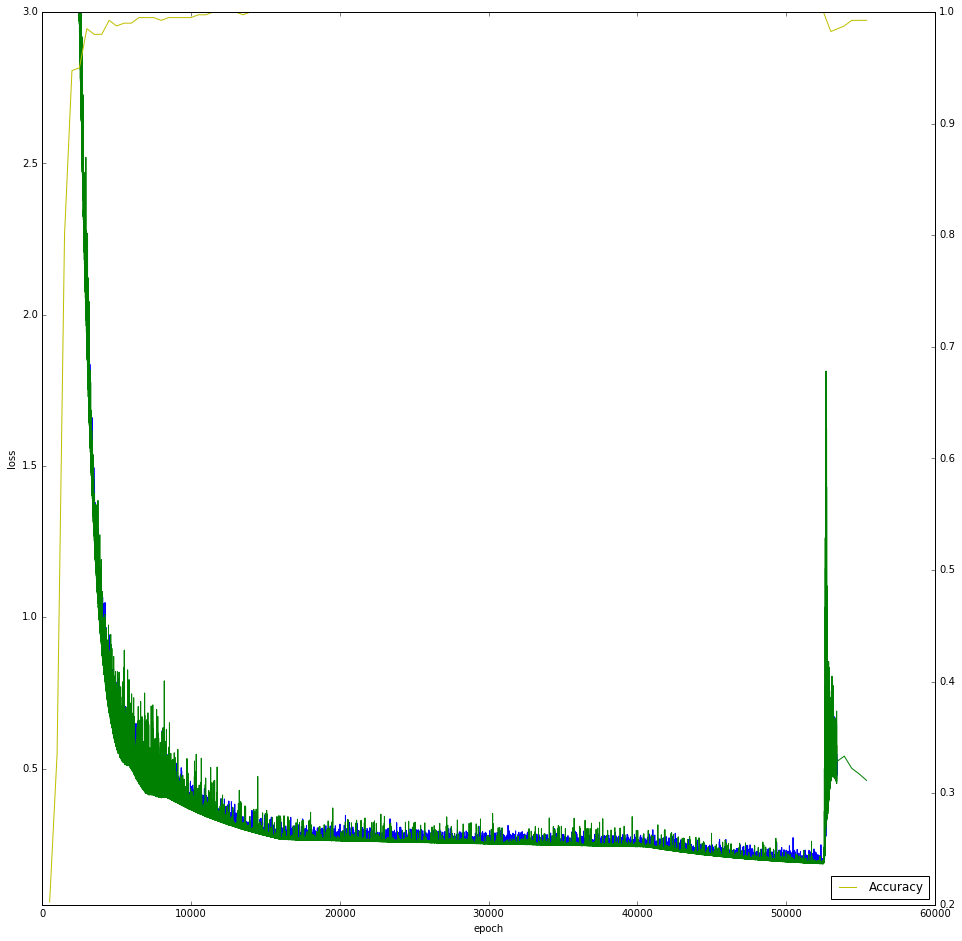

In [7]:
plot_validation_loss(net, validation_file_name,ylim=[0.05,3])

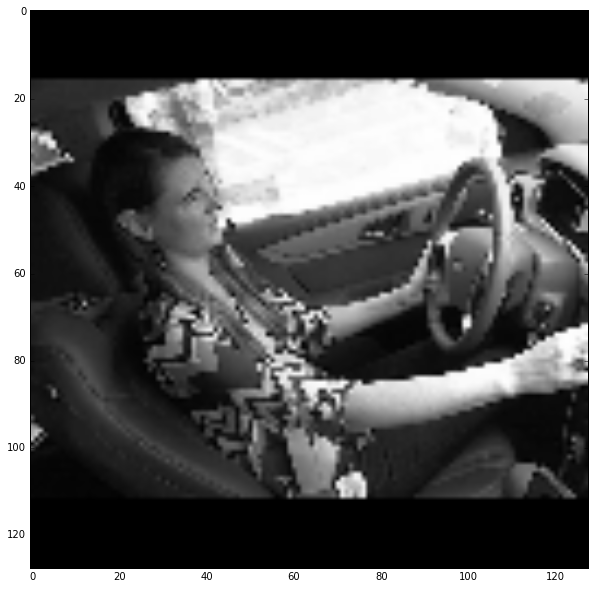

In [8]:
sample = X[0].reshape(1, 1, X[0].shape[0], X[0].shape[1])
plt.figure(figsize=(10,10))
plt.imshow(X[0], cmap='gray')
plt.show()

Original layer shape: (32, 128, 128)
Last shape: (6, 129, 6, 129)
Visualization shape (774, 774):
Prediction 5. [[ 0.00175191  0.00141569  0.00151685  0.001393    0.00121152  0.98788017
   0.00134865  0.00117296  0.00113779  0.00117143]].


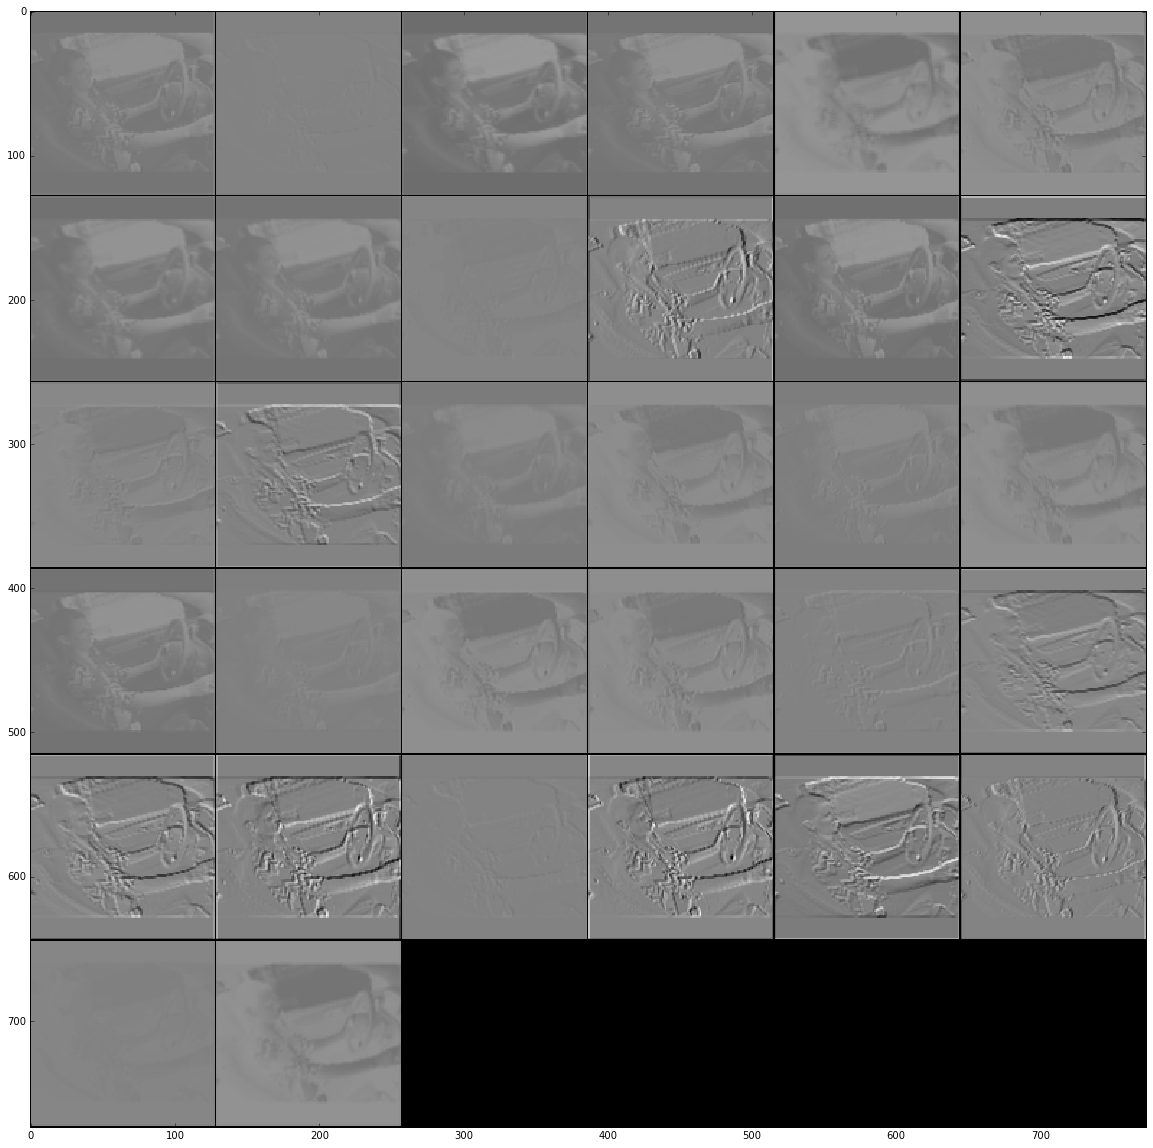

In [9]:
xs = T.tensor4('xs').astype(theano.config.floatX)
get_activity = theano.function([xs], get_output(net.layers_[1], xs))
sample = np.float32(X[0].reshape((1,1,128,128)))
activity = get_activity(sample)
activityS = activity.shape
vis_square(activity.reshape((activityS[1], activityS[2], activityS[3])))
probs = net.predict_proba(sample)
pred = np.argmax(probs)
print("Prediction {}. {}.".format(pred, probs))
plt.show()

# Evaluation Proper

In [10]:
load_best_weights(best_weights_file_name, net)

Loaded parameters to layer 'conv2ddnn1' (shape 32x1x3x3).
Loaded parameters to layer 'batchnorm2' (shape 32).
Loaded parameters to layer 'batchnorm2' (shape 32).
Loaded parameters to layer 'batchnorm2' (shape 32).
Loaded parameters to layer 'batchnorm2' (shape 32).
Loaded parameters to layer 'conv2ddnn4' (shape 32x32x3x3).
Loaded parameters to layer 'batchnorm5' (shape 32).
Loaded parameters to layer 'batchnorm5' (shape 32).
Loaded parameters to layer 'batchnorm5' (shape 32).
Loaded parameters to layer 'batchnorm5' (shape 32).
Loaded parameters to layer 'conv2ddnn9' (shape 64x32x3x3).
Loaded parameters to layer 'batchnorm10' (shape 64).
Loaded parameters to layer 'batchnorm10' (shape 64).
Loaded parameters to layer 'batchnorm10' (shape 64).
Loaded parameters to layer 'batchnorm10' (shape 64).
Loaded parameters to layer 'conv2ddnn12' (shape 64x64x3x3).
Loaded parameters to layer 'batchnorm13' (shape 64).
Loaded parameters to layer 'batchnorm13' (shape 64).
Loaded parameters to layer 'ba

In [11]:
image_gen = image_gen_from_dir_with_filenames(val_dir, 40, input_volume_shape)
threaded_gen = threaded_generator(image_gen, num_cached=40)

all_probs = []
all_file_names = []
for X, file_names in threaded_gen:
    all_probs.extend(net.predict_proba(X.reshape(-1, 1, input_volume_shape[0], input_volume_shape[1])))
    all_file_names.extend(file_names)

In [12]:
df = pd.DataFrame(np.asarray(all_probs), 
                  index = all_file_names, columns=["c0","c1", "c2", "c3", "c4", "c5", "c6", "c7", "c8", "c9"])
df.index.name = 'img'
df.shape

(79726, 10)

In [13]:
df.to_csv("preds.{}.csv".format(dir_name))

In [14]:
df[:10]

,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9
img,,,,,,,,,,
img_73540.jpg,0.003461,0.001194,0.001190,0.003179,0.001003,0.986059,0.001030,0.000871,0.000891,0.001122
img_9672.jpg,0.002991,0.003108,0.978079,0.001257,0.001477,0.001654,0.001990,0.001812,0.004094,0.003537
img_49295.jpg,0.003138,0.000781,0.000741,0.001038,0.989829,0.001006,0.000883,0.000890,0.000666,0.001027
img_91517.jpg,0.002076,0.000488,0.000528,0.000605,0.000416,0.994031,0.000513,0.000507,0.000391,0.000445
img_51925.jpg,0.956837,0.001771,0.001617,0.015358,0.007166,0.008142,0.002167,0.001698,0.001717,0.003526
img_87962.jpg,0.000277,0.000188,0.000178,0.000201,0.000190,0.000231,0.000170,0.997892,0.000325,0.000348
img_30198.jpg,0.010456,0.008835,0.001721,0.967990,0.001936,0.001950,0.002261,0.001503,0.001870,0.001477
img_78210.jpg,0.004047,0.016696,0.006506,0.003991,0.003239,0.003084,0.003648,0.003689,0.920634,0.034465
img_19345.jpg,0.000248,0.000259,0.000330,0.000291,0.997318,0.000266,0.000360,0.000349,0.000314,0.000264
